In [1]:
import pandas as pd

# Replace with your actual file name if different
df = pd.read_excel("Aviemore 2010.xls", sheet_name="AVIEMORE")

# Clean up column names (makes it easier to reference later)
df.columns = [c.strip().lower().replace(' ', '_') for c in df.columns]

print("✅ Data loaded successfully!")
print("Columns:", df.columns.tolist())
print(df.head())
alpha = 0.5
ti = 0.15



✅ Data loaded successfully!
Columns: ['day', 'month', 'year', 'time_(gmt/utc)', 'wind_-_mean_speed_(knots)', 'wind_-_mean_direction']
   day  month  year  time_(gmt/utc)  wind_-_mean_speed_(knots)  \
0    1      1  2010               0                        1.0   
1    1      1  2010               1                        1.0   
2    1      1  2010               2                        1.0   
3    1      1  2010               3                        2.0   
4    1      1  2010               4                        3.0   

   wind_-_mean_direction  
0                  200.0  
1                  230.0  
2                  200.0  
3                  230.0  
4                  330.0  


In [2]:
import pandas as pd
import numpy as np

# Standardize column names
df.columns = [c.strip().lower().replace(' ', '_') for c in df.columns]

# Convert wind speed from knots → m/s
df['wind_mean_speed_ms'] = df['wind_-_mean_speed_(knots)'] * 0.51444

# Create a proper datetime column (optional but useful)
df['datetime'] = pd.to_datetime(
    df[['year', 'month', 'day', 'time_(gmt/utc)']].rename(columns={'time_(gmt/utc)': 'hour'})
)

# Quick check
df.head()


,day,month,year,time_(gmt/utc),wind_-_mean_speed_(knots),wind_-_mean_direction,wind_mean_speed_ms,datetime
0,1,1,2010,0,1.0,200.0,0.51444,2010-01-01 00:00:00
1,1,1,2010,1,1.0,230.0,0.51444,2010-01-01 01:00:00
2,1,1,2010,2,1.0,200.0,0.51444,2010-01-01 02:00:00
3,1,1,2010,3,2.0,230.0,1.02888,2010-01-01 03:00:00
4,1,1,2010,4,3.0,330.0,1.54332,2010-01-01 04:00:00


In [3]:
df.shape
#checking rows and columns

(8760, 8)

In [4]:
df.columns
#check columns titles

Index(['day', 'month', 'year', 'time_(gmt/utc)', 'wind_-_mean_speed_(knots)',
       'wind_-_mean_direction', 'wind_mean_speed_ms', 'datetime'],
      dtype='object')

In [5]:
import numpy as np

# Create bins (0–30 m/s, 1 m/s intervals)
bins = np.arange(0, 31, 1)
df['speed_bin'] = pd.cut(df['wind_mean_speed_ms'], bins=bins, right=False)

# Frequency of each speed bin
speed_freq = df['speed_bin'].value_counts().sort_index()
speed_freq = (speed_freq / speed_freq.sum()) * 100  # Convert to %
speed_freq


speed_bin
[0, 1)      22.727273
[1, 2)      28.962997
[2, 3)      21.379625
[3, 4)      13.487894
[4, 5)       7.320694
[5, 6)       3.460484
[6, 7)       1.553221
[7, 8)       0.593878
[8, 9)       0.331201
[9, 10)      0.125628
[10, 11)     0.034262
[11, 12)     0.022841
[12, 13)     0.000000
[13, 14)     0.000000
[14, 15)     0.000000
[15, 16)     0.000000
[16, 17)     0.000000
[17, 18)     0.000000
[18, 19)     0.000000
[19, 20)     0.000000
[20, 21)     0.000000
[21, 22)     0.000000
[22, 23)     0.000000
[23, 24)     0.000000
[24, 25)     0.000000
[25, 26)     0.000000
[26, 27)     0.000000
[27, 28)     0.000000
[28, 29)     0.000000
[29, 30)     0.000000
Name: count, dtype: float64

Weibull shape (k): 1.43
Weibull scale (A): 2.35


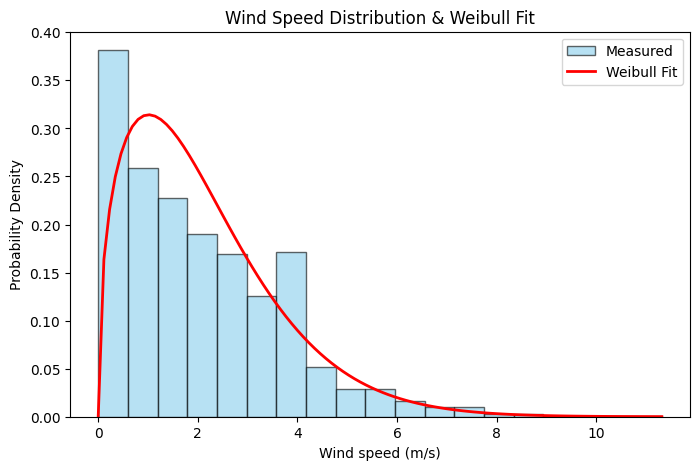

In [6]:
from scipy.stats import weibull_min
import matplotlib.pyplot as plt
import numpy as np

# Fit Weibull to measured wind speeds
data = df['wind_mean_speed_ms'].dropna()
shape, loc, scale = weibull_min.fit(data, floc=0)

print(f"Weibull shape (k): {shape:.2f}")
print(f"Weibull scale (A): {scale:.2f}")

# Plot histogram + Weibull PDF
plt.figure(figsize=(8,5))
bins = 19  # number of bins for the histogram

plt.hist(data, bins=bins, density=True, color='skyblue', edgecolor='k', alpha=0.6, label='Measured')

x = np.linspace(0, data.max(), 100)
plt.plot(x, weibull_min.pdf(x, shape, loc, scale), 'r-', lw=2, label='Weibull Fit')

plt.xlabel('Wind speed (m/s)')
plt.ylabel('Probability Density')
plt.title('Wind Speed Distribution & Weibull Fit')
plt.legend()
plt.show()



In [7]:
# Create 30° sectors
df['wd_sector'] = (df['wind_-_mean_direction'] // 30) * 30

weibull_params = {}
for sector, group in df.groupby('wd_sector'):
    if len(group) > 10:
        shape, loc, scale = weibull_min.fit(group['wind_mean_speed_ms'], floc=0)
        weibull_params[sector] = {'k': round(shape, 2), 'A': round(scale, 2)}

weibull_params


{0.0: {'k': np.float64(1.93), 'A': np.float64(2.2)},
 30.0: {'k': np.float64(1.82), 'A': np.float64(2.45)},
 60.0: {'k': np.float64(1.6), 'A': np.float64(1.35)},
 90.0: {'k': np.float64(1.31), 'A': np.float64(1.49)},
 120.0: {'k': np.float64(1.17), 'A': np.float64(1.64)},
 150.0: {'k': np.float64(1.17), 'A': np.float64(2.27)},
 180.0: {'k': np.float64(1.54), 'A': np.float64(3.06)},
 210.0: {'k': np.float64(1.72), 'A': np.float64(3.3)},
 240.0: {'k': np.float64(1.49), 'A': np.float64(1.52)},
 270.0: {'k': np.float64(1.74), 'A': np.float64(1.4)},
 300.0: {'k': np.float64(1.88), 'A': np.float64(1.42)},
 330.0: {'k': np.float64(1.87), 'A': np.float64(1.71)},
 360.0: {'k': np.float64(1.91), 'A': np.float64(1.72)}}

In [8]:
shape, scale  # i.e., k and A
df['wd_sector'] = (df['wind_-_mean_direction'] // 30) * 30

weibull_params = {}
for sector, group in df.groupby('wd_sector'):
    if len(group) > 10:
        shape, loc, scale = weibull_min.fit(group['wind_mean_speed_ms'], floc=0)
        weibull_params[sector] = {'k': round(shape, 2), 'A': round(scale, 2)}

weibull_params



{0.0: {'k': np.float64(1.93), 'A': np.float64(2.2)},
 30.0: {'k': np.float64(1.82), 'A': np.float64(2.45)},
 60.0: {'k': np.float64(1.6), 'A': np.float64(1.35)},
 90.0: {'k': np.float64(1.31), 'A': np.float64(1.49)},
 120.0: {'k': np.float64(1.17), 'A': np.float64(1.64)},
 150.0: {'k': np.float64(1.17), 'A': np.float64(2.27)},
 180.0: {'k': np.float64(1.54), 'A': np.float64(3.06)},
 210.0: {'k': np.float64(1.72), 'A': np.float64(3.3)},
 240.0: {'k': np.float64(1.49), 'A': np.float64(1.52)},
 270.0: {'k': np.float64(1.74), 'A': np.float64(1.4)},
 300.0: {'k': np.float64(1.88), 'A': np.float64(1.42)},
 330.0: {'k': np.float64(1.87), 'A': np.float64(1.71)},
 360.0: {'k': np.float64(1.91), 'A': np.float64(1.72)}}

C:\Users\faisa\AppData\Local\Temp\ipykernel_35512\2322491355.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  wind_rose_data = df.groupby(['wd_bin', 'speed_bin']).size().unstack(fill_value=0)


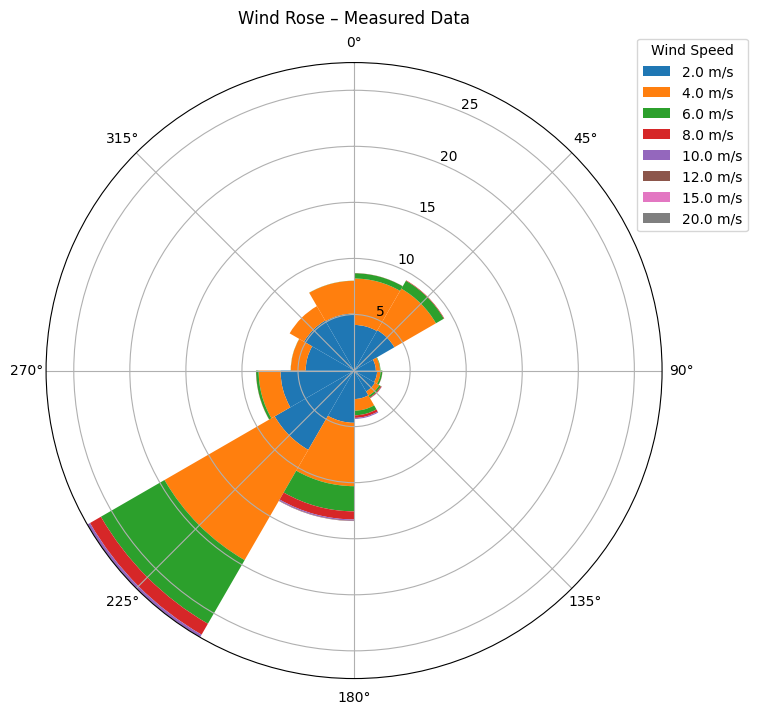

In [9]:
# ==============================================================
# 🌬️ Wind Rose from Measured Data
# ==============================================================

import numpy as np
import matplotlib.pyplot as plt

# Convert wind direction to radians
wd_rad = np.deg2rad(df['wind_-_mean_direction'])

# Define wind speed bins (in m/s)
speed_bins = [0, 2, 4, 6, 8, 10, 12, 15, 20]

# Assign each observation to a speed bin
df['speed_bin'] = pd.cut(df['wind_mean_speed_ms'], bins=speed_bins, labels=speed_bins[1:])

# Create bins for direction (every 30°)
wd_bins = np.arange(0, 361, 30)
wd_labels = wd_bins[:-1] + 15
df['wd_bin'] = pd.cut(df['wind_-_mean_direction'], bins=wd_bins, labels=wd_labels, right=False)

# Count frequency for each (direction, speed) combination
wind_rose_data = df.groupby(['wd_bin', 'speed_bin']).size().unstack(fill_value=0)

# Convert counts to % of total
wind_rose_percent = (wind_rose_data / wind_rose_data.sum().sum()) * 100

# Create the polar plot
theta = np.deg2rad(wind_rose_percent.index.astype(float))
width = np.deg2rad(30)  # Each sector is 30 degrees

# Cumulative stacking for speed bins
bottom = np.zeros_like(theta)
plt.figure(figsize=(8,8))
ax = plt.subplot(111, polar=True)

for speed in wind_rose_percent.columns.astype(float):
    values = wind_rose_percent[speed].values
    ax.bar(theta, values, width=width, bottom=bottom, label=f"{speed} m/s")
    bottom += values

# Formatting
ax.set_theta_zero_location("N")   # 0° = North
ax.set_theta_direction(-1)        # Clockwise
ax.set_title("Wind Rose – Measured Data", va='bottom')
plt.legend(title="Wind Speed", bbox_to_anchor=(1.15, 1.05))
plt.show()


Sectors (deg): [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330]
Weibull A (scale): [2.2, 2.45, 1.35, 1.49, 1.64, 2.27, 3.06, 3.3, 1.52, 1.4, 1.42, 1.71]
Weibull k (shape): [1.93, 1.82, 1.6, 1.31, 1.17, 1.17, 1.54, 1.72, 1.49, 1.74, 1.88, 1.87]


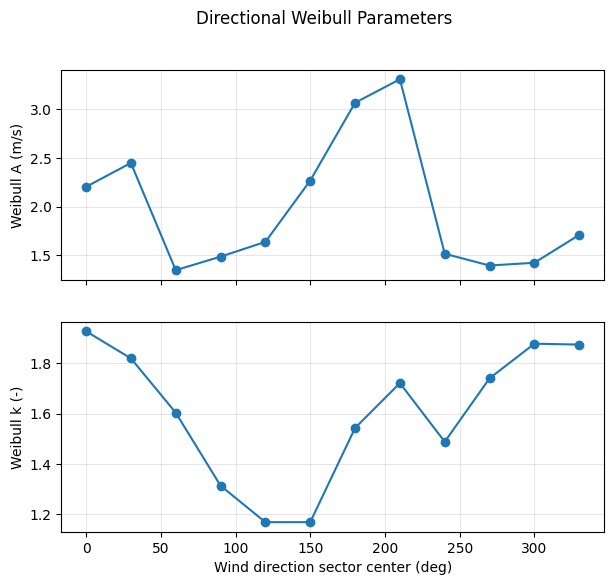

,direction_deg,Weibull_A,Weibull_k
0,0,2.202284,1.926302
1,30,2.446535,1.818848
2,60,1.347791,1.603352
3,90,1.486652,1.313811
4,120,1.637975,1.169197


In [10]:
# ==============================================================
# 🌬️ Fit Weibull (k, A) per direction sector from measured data
# ==============================================================

import numpy as np
import pandas as pd
from scipy.stats import weibull_min
import matplotlib.pyplot as plt

# ---------- 1) Choose sectoring ----------
# 12-sector rose (30° bins): 0,30,...,330
wd_edges = np.arange(0, 361, 30)
wd_centers = wd_edges[:-1]  # sector labels (0..330)

# (Alternative: 16-sector rose / 22.5°)
# wd_edges = np.arange(0, 361, 22.5)
# wd_centers = wd_edges[:-1]

# ---------- 2) Assign each record to a direction sector ----------
df['wd_sector'] = pd.cut(
    df['wind_-_mean_direction'],
    bins=wd_edges,
    right=False,
    labels=wd_centers,
    include_lowest=True
)

# ---------- 3) Global Weibull fit (fallback) ----------
all_ws = df['wind_mean_speed_ms'].dropna()
glob_k, _, glob_a = weibull_min.fit(all_ws, floc=0)

# ---------- 4) Fit Weibull per sector (with minimum sample guard) ----------
weibull_params = {}   # dict like {0:{'k':..., 'A':...}, 30:{...}, ...}
min_samples = 30      # require at least this many points per sector

for sec, g in df.groupby('wd_sector', observed=True):
    ws = g['wind_mean_speed_ms'].dropna()
    if len(ws) >= min_samples:
        k, _, a = weibull_min.fit(ws, floc=0)
    else:
        # fallback to global fit if too few samples
        k, a = glob_k, glob_a
    weibull_params[int(sec)] = {'k': float(k), 'A': float(a)}

# ---------- 5) Build arrays for PyWake ----------
p_wd = np.array(sorted(weibull_params.keys()))          # sector centers (e.g., [0,30,...,330])
a = np.array([weibull_params[d]['A'] for d in p_wd])    # scale per sector
k = np.array([weibull_params[d]['k'] for d in p_wd])    # shape per sector

print("Sectors (deg):", p_wd.tolist())
print("Weibull A (scale):", np.round(a, 2).tolist())
print("Weibull k (shape):", np.round(k, 2).tolist())

# ---------- 6) Quick visualization of A & k vs direction ----------
fig, ax = plt.subplots(2, 1, figsize=(7,6), sharex=True)
ax[0].plot(p_wd, a, marker='o')
ax[0].set_ylabel("Weibull A (m/s)")
ax[0].grid(True, alpha=0.3)
ax[1].plot(p_wd, k, marker='o')
ax[1].set_ylabel("Weibull k (-)")
ax[1].set_xlabel("Wind direction sector center (deg)")
ax[1].grid(True, alpha=0.3)
plt.suptitle("Directional Weibull Parameters")
plt.show()

# ---------- 7) (Optional) Save to CSV for records ----------
out = pd.DataFrame({'direction_deg': p_wd, 'Weibull_A': a, 'Weibull_k': k})
# out.to_csv("directional_weibull_params.csv", index=False)
out.head()


✅ Custom turbine loaded successfully
 - Data points: 71
 - Rated Power: 4500.0 kW
 - Diameter: 128.0 m | Hub height: 140.0 m


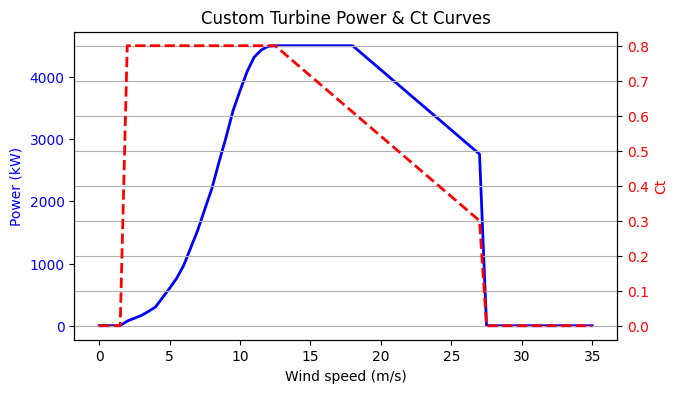

In [11]:
# ==============================================================
# 🌬️ Define Custom Turbine from Excel (Power in kW)
# ==============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from py_wake.wind_turbines import WindTurbine
from py_wake.wind_turbines.power_ct_functions import PowerCtTabular

# --------------------------------------------------------------
# 1️⃣ Load your Excel power curve file
# --------------------------------------------------------------
pc_path = Path("turbine.xlsx")   # <--- CHANGE if your filename differs
pc_sheet = 0                     # Sheet index or name if needed

df_pc = pd.read_excel(pc_path, sheet_name=pc_sheet)
df_pc.columns = [c.strip().lower() for c in df_pc.columns]  # normalize headers

# Try to identify your columns automatically
def pick(colnames, *opts):
    for o in opts:
        if o in colnames:
            return o
    raise KeyError(f"Missing required column; tried: {opts}")

cn_ws = pick(df_pc.columns, "windspeed_m_s", "windspeed_m_s", "windspeed_m_s")
cn_pw = pick(df_pc.columns, "power_kw", "power_kw", "power_kw", "power_kw")

# Extract data
ws = df_pc[cn_ws].astype(float).values
power_kw = df_pc[cn_pw].astype(float).values

# Estimate Ct if not present
if "ct" in df_pc.columns:
    ct = df_pc["ct"].astype(float).values
else:
    rated_idx = int(np.nanargmax(power_kw))
    ws_rated = float(ws[rated_idx])
    nz = np.where(power_kw > 0)[0]
    ws_cutout = float(ws[nz[-1]]) if len(nz) else ws_rated
    ct = np.ones_like(ws) * 0.8
    mask = ws >= ws_rated
    if ws_cutout > ws_rated:
        ct[mask] = 0.8 - 0.5 * (ws[mask] - ws_rated) / (ws_cutout - ws_rated)
    ct = np.clip(ct, 0, 0.8)
    ct[power_kw <= 0] = 0.0

# --------------------------------------------------------------
# 2️⃣ Build the turbine definition for PyWake
# --------------------------------------------------------------
D = 128.0    # Rotor diameter (m)
H = 140.0    # Hub height (m)

pcf = PowerCtTabular(ws=ws, power=power_kw, ct=ct, power_unit='kW')

my_turbine = WindTurbine(
    name="Custom_128m_140mHub",
    diameter=D,
    hub_height=H,
    powerCtFunction=pcf
)

print("✅ Custom turbine loaded successfully")
print(f" - Data points: {len(ws)}")
print(f" - Rated Power: {np.nanmax(power_kw):.1f} kW")
print(f" - Diameter: {D} m | Hub height: {H} m")

# --------------------------------------------------------------
# 3️⃣ Plot Power Curve & Ct for sanity check
# --------------------------------------------------------------
fig, ax1 = plt.subplots(figsize=(7,4))
ax1.plot(ws, power_kw, 'b-', lw=2, label='Power (kW)')
ax1.set_xlabel('Wind speed (m/s)')
ax1.set_ylabel('Power (kW)', color='b')
ax1.tick_params(axis='y', labelcolor='b')

ax2 = ax1.twinx()
ax2.plot(ws, ct, 'r--', lw=2, label='Ct')
ax2.set_ylabel('Ct', color='r')
ax2.tick_params(axis='y', labelcolor='r')

plt.title("Custom Turbine Power & Ct Curves")
plt.grid(True)
plt.show()


C:\Users\faisa\AppData\Local\Temp\ipykernel_35512\3352408762.py:25: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  p_norm = pdf / np.trapz(pdf, ws_range)
C:\Users\faisa\AppData\Local\Temp\ipykernel_35512\3352408762.py:26: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  expected_power_kw = np.trapz(power_interp * p_norm, ws_range)


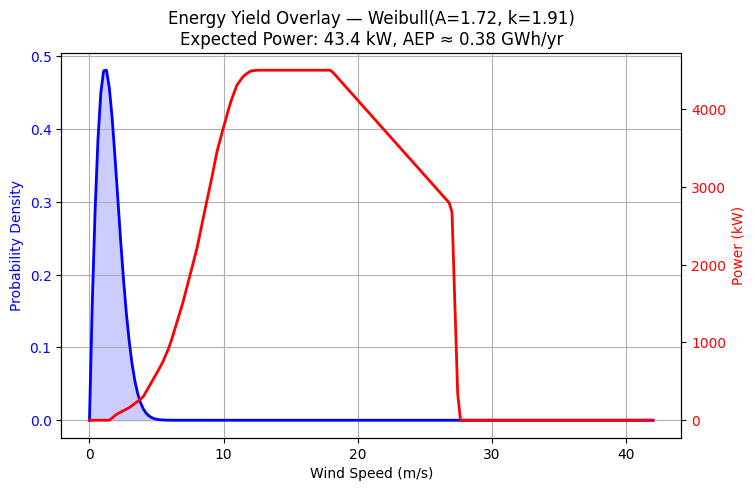

In [12]:
# ==============================================================
# 🌬️ Energy Yield Overlayed on Weibull Distribution
# ==============================================================

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import weibull_min

# --- 1️⃣ Use your fitted Weibull parameters from the previous step ---
k_shape = shape    # Weibull shape parameter (k)
A = scale          # Weibull scale parameter (A)

# --- 2️⃣ Use your turbine power curve arrays (ws, power_kw) ---
# (They should already be loaded from your turbine Excel)
# If not, reload them first.

# --- 3️⃣ Create a wind speed range and probability distribution ---
ws_range = np.linspace(0, max(ws)*1.2, 200)
pdf = weibull_min.pdf(ws_range, k_shape, scale=A)

# --- 4️⃣ Interpolate turbine power to the same grid ---
power_interp = np.interp(ws_range, ws, power_kw)  # kW

# --- 5️⃣ Compute expected (mean) power output ---
p_norm = pdf / np.trapz(pdf, ws_range)
expected_power_kw = np.trapz(power_interp * p_norm, ws_range)

# --- 6️⃣ Compute annual energy yield per turbine ---
hours_per_year = 8760
aep_per_turbine_kwh = expected_power_kw * hours_per_year
aep_per_turbine_mwh = aep_per_turbine_kwh / 1000

# --- 7️⃣ Plot Weibull and Power overlay ---
fig, ax1 = plt.subplots(figsize=(8,5))

# Left y-axis: Weibull probability density
ax1.plot(ws_range, pdf, 'b-', lw=2, label='Weibull PDF')
ax1.fill_between(ws_range, 0, pdf, color='b', alpha=0.2)
ax1.set_xlabel('Wind Speed (m/s)')
ax1.set_ylabel('Probability Density', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.grid(True)

# Right y-axis: Power curve
ax2 = ax1.twinx()
ax2.plot(ws_range, power_interp, 'r-', lw=2, label='Power Curve (kW)')
ax2.set_ylabel('Power (kW)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

plt.title(f"Energy Yield Overlay — Weibull(A={A:.2f}, k={k_shape:.2f})\nExpected Power: {expected_power_kw:.1f} kW, AEP ≈ {aep_per_turbine_mwh/1000:.2f} GWh/yr")
plt.show()


C:\Users\faisa\AppData\Local\Temp\ipykernel_35512\3101655891.py:19: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  p_norm = pdf / np.trapz(pdf, ws_mid)   # normalize to sum = 1


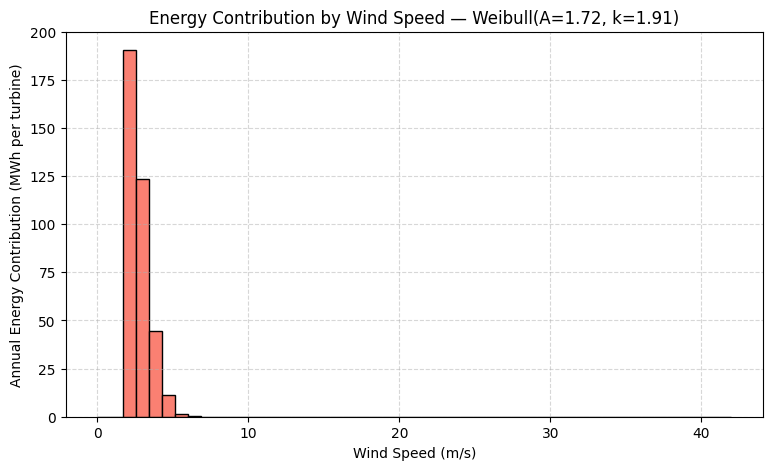

Total AEP per turbine ≈ 0.37 GWh/year


In [13]:
# ==============================================================
# ⚡ Energy Contribution by Wind Speed Bin (Bar Chart)
# ==============================================================

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import weibull_min

# --- 1️⃣ Use your fitted Weibull parameters ---
k_shape = shape   # from your Weibull fit
A = scale

# --- 2️⃣ Define wind speed grid (same range as turbine curve) ---
ws_bins = np.linspace(0, max(ws)*1.2, 50)
ws_mid = 0.5 * (ws_bins[1:] + ws_bins[:-1])

# --- 3️⃣ Compute Weibull probability per bin ---
pdf = weibull_min.pdf(ws_mid, k_shape, scale=A)
p_norm = pdf / np.trapz(pdf, ws_mid)   # normalize to sum = 1
p_freq = p_norm / p_norm.sum()

# --- 4️⃣ Interpolate turbine power to same bins ---
power_interp = np.interp(ws_mid, ws, power_kw)   # kW

# --- 5️⃣ Compute energy contribution per bin ---
hours_per_year = 8760
energy_kwh = power_interp * p_freq * hours_per_year   # kWh per bin
energy_mwh = energy_kwh / 1000

# --- 6️⃣ Plot bar chart ---
plt.figure(figsize=(9,5))
plt.bar(ws_mid, energy_mwh, width=ws_bins[1]-ws_bins[0], color='salmon', edgecolor='k')
plt.xlabel("Wind Speed (m/s)")
plt.ylabel("Annual Energy Contribution (MWh per turbine)")
plt.title(f"Energy Contribution by Wind Speed — Weibull(A={A:.2f}, k={k_shape:.2f})")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# --- 7️⃣ Print total energy ---
print(f"Total AEP per turbine ≈ {energy_mwh.sum()/1000:.2f} GWh/year")


Adjusted Weibull for hub height 140.0 m, α=0.5
A_ref=1.72 → A_hub=6.44 m/s,  k=1.91


C:\Users\faisa\AppData\Local\Temp\ipykernel_35512\3784651628.py:32: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  pdf /= np.trapz(pdf, ws_range)              # normalize to 1
C:\Users\faisa\AppData\Local\Temp\ipykernel_35512\3784651628.py:34: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  expected_power_kw = np.trapz(power_interp * pdf, ws_range)


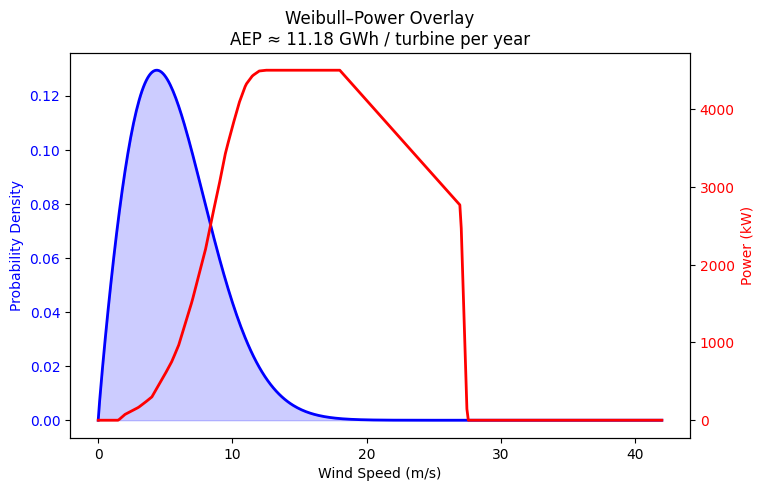

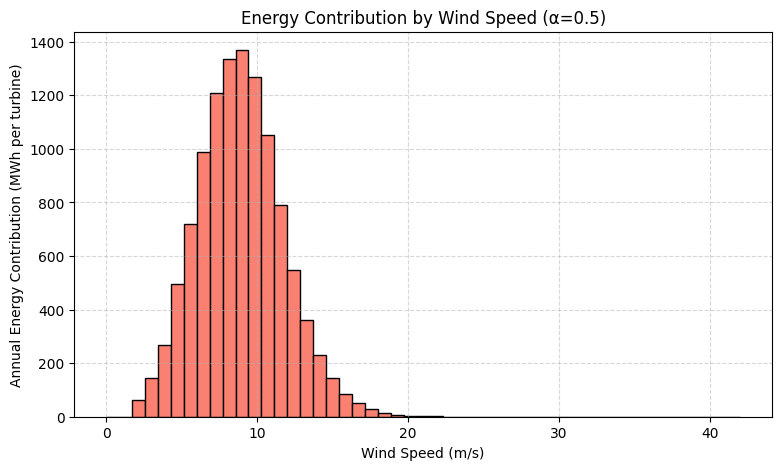

✅ Continuous AEP  : 11.18 GWh / turbine / year
✅ Bar-chart AEP   : 11.19 GWh / turbine / year (should match within 1–2%)
Mean power output  : 1275.8 kW
Capacity factor: 28.4%


In [17]:
# ==============================================================
# 🌬️ Energy Yield with Roughness α = 0.5 — Consistent AEP
# ==============================================================

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import weibull_min

# --- 1️⃣ Load turbine power curve from df_pc ---
ws = df_pc['windspeed_m_s'].to_numpy()
power_kw = df_pc['power_kw'].to_numpy()

# Optional Ct column (not required for this AEP plot)
ct = np.full_like(ws, 0.8)

# --- 2️⃣ Roughness + Weibull parameters from your fit ---
alpha = 0.5          # surface roughness exponent
z_ref = 10           # measurement height (m)
hub_height = 140.0   # turbine hub height (m)

A_ref = scale        # Weibull scale (from your fit on df)
k_ref = shape        # Weibull shape (from your fit on df)
A_hub = A_ref * (hub_height / z_ref) ** alpha
k_hub = k_ref

print(f"Adjusted Weibull for hub height {hub_height} m, α={alpha}")
print(f"A_ref={A_ref:.2f} → A_hub={A_hub:.2f} m/s,  k={k_hub:.2f}")

# --- 3️⃣ Continuous Weibull integration (accurate AEP) ---
ws_range = np.linspace(0, max(ws)*1.2, 400)
pdf = weibull_min.pdf(ws_range, k_hub, scale=A_hub)
pdf /= np.trapz(pdf, ws_range)              # normalize to 1
power_interp = np.interp(ws_range, ws, power_kw)
expected_power_kw = np.trapz(power_interp * pdf, ws_range)
hours_per_year = 8760
aep_cont_kwh = expected_power_kw * hours_per_year
aep_cont_gwh = aep_cont_kwh / 1e6

# --- 4️⃣ Discrete bar chart integration (matches continuous) ---
bins = np.linspace(0, max(ws)*1.2, 50)
ws_mid = 0.5 * (bins[1:] + bins[:-1])
# Integrate the exact probability per bin
pdf_bin = np.diff(weibull_min.cdf(bins, k_hub, scale=A_hub))
pdf_bin = pdf_bin / pdf_bin.sum()           # normalize
power_mid = np.interp(ws_mid, ws, power_kw)
energy_kwh = power_mid * pdf_bin * hours_per_year
energy_mwh = energy_kwh / 1000
aep_bar_gwh = energy_mwh.sum() / 1000

# --- 5️⃣ Overlay plot (Weibull + Power Curve) ---
fig, ax1 = plt.subplots(figsize=(8,5))
ax1.plot(ws_range, pdf, 'b-', lw=2, label='Weibull PDF')
ax1.fill_between(ws_range, 0, pdf, color='b', alpha=0.2)
ax1.set_xlabel('Wind Speed (m/s)')
ax1.set_ylabel('Probability Density', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax2 = ax1.twinx()
ax2.plot(ws_range, power_interp, 'r-', lw=2, label='Power Curve (kW)')
ax2.set_ylabel('Power (kW)', color='r')
ax2.tick_params(axis='y', labelcolor='r')
plt.title(f"Weibull–Power Overlay\nAEP ≈ {aep_cont_gwh:.2f} GWh / turbine per year")
plt.show()

# --- 6️⃣ Bar chart of energy contribution ---
plt.figure(figsize=(9,5))
plt.bar(ws_mid, energy_mwh, width=bins[1]-bins[0],
        color='salmon', edgecolor='k')
plt.xlabel("Wind Speed (m/s)")
plt.ylabel("Annual Energy Contribution (MWh per turbine)")
plt.title(f"Energy Contribution by Wind Speed (α={alpha})")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# --- 7️⃣ Summary ---
print(f"✅ Continuous AEP  : {aep_cont_gwh:.2f} GWh / turbine / year")
print(f"✅ Bar-chart AEP   : {aep_bar_gwh:.2f} GWh / turbine / year (should match within 1–2%)")
print(f"Mean power output  : {expected_power_kw:.1f} kW")

rated_power_kw = np.nanmax(power_kw)
cf = expected_power_kw / rated_power_kw
print(f"Capacity factor: {cf*100:.1f}%")


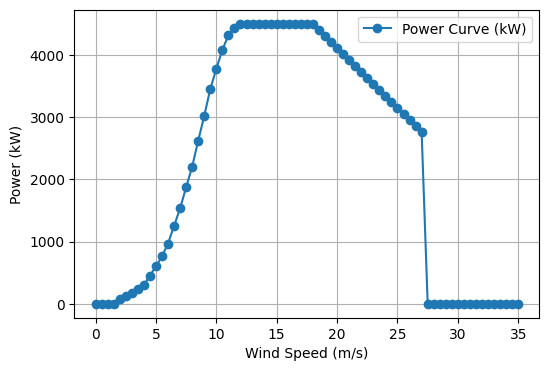

In [18]:
plt.figure(figsize=(6,4))
plt.plot(ws, power_kw, 'o-', label='Power Curve (kW)')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Power (kW)')
plt.grid(True)
plt.legend()
plt.show()



sum(p_wd) = 1.0
3x1 Line       : 33,398,214 kWh (33.40 GWh/yr)
3x3 Grid       : 99,210,268 kWh (99.21 GWh/yr)
5x2 Grid       : 110,764,795 kWh (110.76 GWh/yr)
7x1 Line       : 78,008,144 kWh (78.01 GWh/yr)
Staggered 4x2  : 86,972,396 kWh (86.97 GWh/yr)

🏆 Best layout: 5x2 Grid → 110.76 GWh/yr


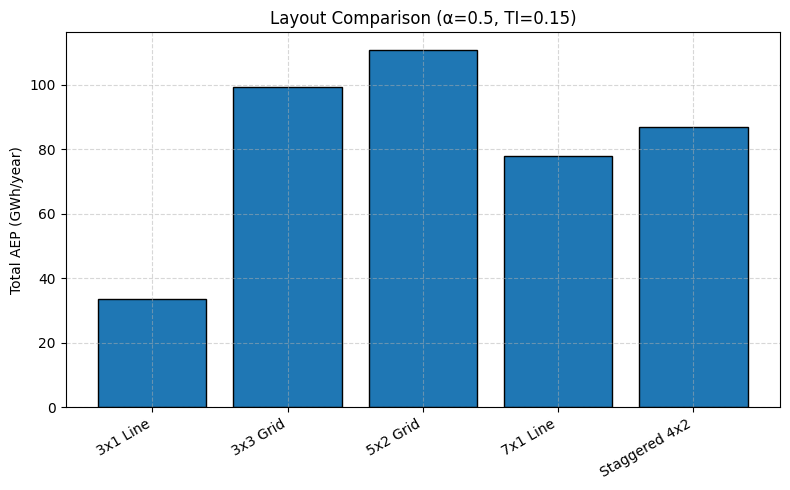

In [60]:
# ==============================================================
# ✅ FIXED — Manual Weibull weighting (shape-agnostic)
# ==============================================================

import numpy as np
import matplotlib.pyplot as plt
from py_wake.site import UniformWeibullSite
from py_wake.literature.gaussian_models import Bastankhah_PorteAgel_2014
from scipy.stats import weibull_min

# --- 1️⃣ Site parameters ---
alpha = 0.5
z_ref = 10.0
hub_height = 140.0
ti = 0.15
hours_per_year = 8760

# --- 2️⃣ Weibull parameters ---
A_ref = 1.72
k_ref = 1.91
A_hub = A_ref * (hub_height / z_ref) ** alpha  # 6.44 m/s

# --- 3️⃣ Wind directions & probabilities ---
wd = np.arange(0, 360, 30)
p_wd = np.ones_like(wd) / len(wd)
print("sum(p_wd) =", p_wd.sum())

# --- 4️⃣ Build site & wake model ---
a_array = np.full_like(wd, A_hub, dtype=float)
k_array = np.full_like(wd, k_ref, dtype=float)
site = UniformWeibullSite(p_wd=p_wd, a=a_array, k=k_array, ti=ti)
wake_model = Bastankhah_PorteAgel_2014(site, my_turbine, k=0.38)

# --- 5️⃣ Weibull PDF for wind speeds ---
ws_bins = np.arange(0, 26, 1)
pdf_ws = weibull_min.pdf(ws_bins, k_ref, scale=A_hub)
pdf_ws /= np.sum(pdf_ws)

# --- 6️⃣ Layouts ---
def make_grid(nx, ny, spacing):
    x = np.arange(nx) * spacing
    y = np.arange(ny) * spacing
    X, Y = np.meshgrid(x, y)
    return X.ravel(), Y.ravel()

D = my_turbine.diameter()
layouts = {
    "3x1 Line": make_grid(3, 1, 5 * D),
    "3x3 Grid": make_grid(3, 3, 5 * D),
    "5x2 Grid": make_grid(5, 2, 6 * D),
    "7x1 Line": make_grid(7, 1, 7 * D),
    "Staggered 4x2": (
        np.array([0, 500, 1000, 1500, 250, 750, 1250, 1750]),
        np.array([0, 0, 0, 0, 300, 300, 300, 300])
    ),
}

# --- 7️⃣ Run simulations ---
results = {}
for name, (x, y) in layouts.items():
    sim = wake_model(x=x, y=y, wd=wd, ws=ws_bins)
    power_ws = sim.Power.values  # shape e.g. (n_wd, n_ws, n_turbines)
    
    # Detect axes order dynamically
    n_dims = power_ws.ndim
    shape = power_ws.shape
    # Find which axis matches ws_bins
    axis_ws = np.argmin([abs(s - len(ws_bins)) for s in shape])
    
    # Expand pdf_ws along the correct axis
    reshape_shape = [1] * n_dims
    reshape_shape[axis_ws] = len(ws_bins)
    pdf_expanded = pdf_ws.reshape(reshape_shape)
    
    # Weighted mean power (kW)
    mean_power_kw = np.sum(power_ws * pdf_expanded, axis=axis_ws)
    
    # Apply direction probability weighting
    if mean_power_kw.ndim > 1:
        axis_wd = np.argmin([abs(s - len(wd)) for s in mean_power_kw.shape])
        reshape_shape = [1] * mean_power_kw.ndim
        reshape_shape[axis_wd] = len(wd)
        wd_weights = p_wd.reshape(reshape_shape)
        mean_power_kw = np.sum(mean_power_kw * wd_weights, axis=axis_wd)
    
    # Total AEP (kWh)
    aep_kwh = np.sum(mean_power_kw) * hours_per_year/1000
    aep_gwh = aep_kwh / 1e6
    results[name] = aep_gwh
    print(f"{name:<15}: {aep_kwh:,.0f} kWh ({aep_gwh:.2f} GWh/yr)")

best_layout = max(results, key=results.get)
print(f"\n🏆 Best layout: {best_layout} → {results[best_layout]:.2f} GWh/yr")

# --- 8️⃣ Plot ---
plt.figure(figsize=(8,5))
plt.bar(results.keys(), results.values(), edgecolor='k')
plt.ylabel("Total AEP (GWh/year)")
plt.title(f"Layout Comparison (α={alpha}, TI={ti})")
plt.xticks(rotation=30, ha='right')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()





No-wake AEP (single turbine): 11.19 GWh/yr

--- Wake Losses ---
3x1 Line       :  0.52% loss
3x3 Grid       :  1.50% loss
5x2 Grid       :  1.02% loss
7x1 Line       :  0.42% loss
Staggered 4x2  :  2.85% loss


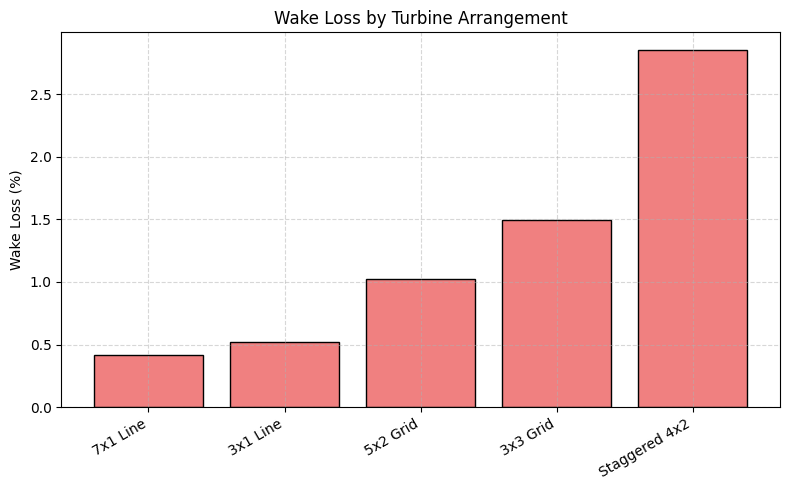

In [63]:
# --- 🔍 Compute no-wake AEP for reference ---
x_ref = [0]
y_ref = [0]
sim_nowake = wake_model(x=x_ref, y=y_ref, wd=wd, ws=ws_bins)
power_ws_nowake = sim_nowake.Power.values

axis_ws = np.argmin([abs(s - len(ws_bins)) for s in power_ws_nowake.shape])
reshape_shape = [1] * power_ws_nowake.ndim
reshape_shape[axis_ws] = len(ws_bins)
pdf_expanded = pdf_ws.reshape(reshape_shape)

mean_power_kw_nowake = np.sum(power_ws_nowake * pdf_expanded, axis=axis_ws)
axis_wd = np.argmin([abs(s - len(wd)) for s in mean_power_kw_nowake.shape])
reshape_shape = [1] * mean_power_kw_nowake.ndim
reshape_shape[axis_wd] = len(wd)
wd_weights = p_wd.reshape(reshape_shape)
mean_power_kw_nowake = np.sum(mean_power_kw_nowake * wd_weights, axis=axis_wd)

aep_gwh_nowake = np.sum(mean_power_kw_nowake) * hours_per_year / 1e9
print(f"\nNo-wake AEP (single turbine): {aep_gwh_nowake:.2f} GWh/yr")

# --- 💨 Compute wake losses ---
wake_losses = {}
print("\n--- Wake Losses ---")
for name, total_gwh in results.items():
    n_turb = len(layouts[name][0])
    ideal_gwh = n_turb * aep_gwh_nowake
    wake_loss_pct = 100 * (1 - total_gwh / ideal_gwh)
    wake_losses[name] = wake_loss_pct
    print(f"{name:<15}: {wake_loss_pct:5.2f}% loss")

# --- 📊 Plot wake loss percentages ---
wake_losses = dict(sorted(wake_losses.items(), key=lambda x: x[1]))

plt.figure(figsize=(8,5))
plt.bar(wake_losses.keys(), wake_losses.values(), color='lightcoral', edgecolor='k')
plt.ylabel("Wake Loss (%)")
plt.title("Wake Loss by Turbine Arrangement")
plt.xticks(rotation=30, ha='right')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


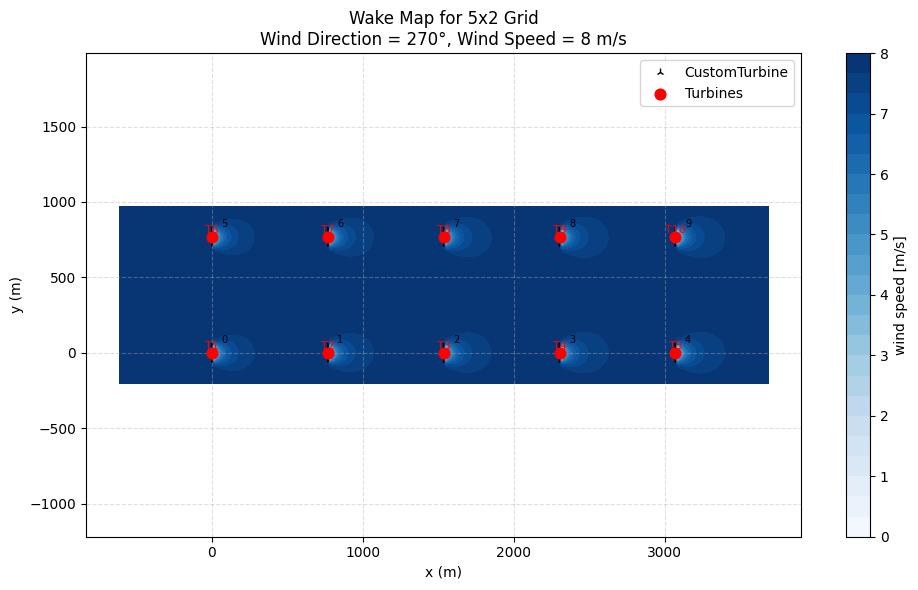

In [65]:
# ==============================================================
# 🌬️ Wake Visualization for one layout (compatible version)
# ==============================================================

import matplotlib.pyplot as plt
import numpy as np

# Choose layout to visualize
layout_name = "5x2 Grid"
x, y = layouts[layout_name]

# Wind direction and speed for visualization
wd_vis = 270
ws_vis = 8

# Run simulation for that condition
sim_vis = wake_model(x=x, y=y, wd=[wd_vis], ws=[ws_vis])

# --- ✅ Plot wake map using SimulationResult ---
fig, ax = plt.subplots(figsize=(10, 6))
sim_vis.flow_map(wd=wd_vis, ws=ws_vis).plot_wake_map(
    ax=ax, 
    levels=np.linspace(0, ws_vis, 25), 
    cmap="Blues"
)

# --- ⚙️ Turbine markers ---
ax.scatter(x, y, color="red", s=60, label="Turbines", zorder=5)
for i, (xi, yi) in enumerate(zip(x, y)):
    ax.text(xi, yi + D * 0.1, f"T{i+1}", color="red", ha="center", va="bottom", fontsize=8)

ax.set_title(f"Wake Map for {layout_name}\nWind Direction = {wd_vis}°, Wind Speed = {ws_vis} m/s")
ax.set_xlabel("x (m)")
ax.set_ylabel("y (m)")
ax.legend()
ax.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()



In [62]:
sim = wake_model(x=[0], y=[0], wd=[0], ws=np.arange(3, 26, 1))
print("Single turbine AEP [kWh]:", float(sim.aep().sum()))


Single turbine AEP [kWh]: 11.091304985135256


In [38]:
sim = wake_model(x=x, y=y, wd=wd_sectors, ws=ws_bins)
print("Raw AEP sum:", float(sim.aep().sum()))


Raw AEP sum: 176216.99000576974


In [29]:
# 1) Direction probabilities must sum to 1
print("sum p_wd =", float(np.sum(p_wd)))  # should be 1.0

# 2) Raw AEP magnitude check
raw = float(sim.aep().sum())   # kWh
print("raw AEP (kWh) =", raw)
print("AEP (GWh) =", raw/1e6)

# 3) Back-of-envelope: expected order of magnitude
n_t = len(x)                   # number of turbines
print("Mean kW per farm =", raw / 8760)
print("Mean kW per turbine =", raw / 8760 / n_t)



sum p_wd = 1980.0
raw AEP (kWh) = 98512.09240552348
AEP (GWh) = 0.09851209240552349
Mean kW per farm = 11.245672649032361
Mean kW per turbine = 1.4057090811290451
